In [28]:
import numpy as np 
import pandas as pd 
import json
from transformers import * 
import os
from tqdm.auto import tqdm 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler 
import pickle 
import time 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

In [2]:
with open("qa_json(full).json") as f: 
    d = json.load(f) 

In [3]:
queries, passages, answers = [], [], [] 

for i in tqdm(range(len(d)), position=0, leave=True): 
    query = d[i]["query"] 
    passage = d[i]["passages"]
    answer = d[i]["answer"] 
    queries.append(query) 
    passages.append(passage[0])  
    answers.append(answer) 

  0%|          | 0/6786 [00:00<?, ?it/s]

In [4]:
all_data = pd.DataFrame(list(zip(queries, passages, answers)), columns=["queries", "passages", "answers"])

all_data.head()  

,queries,passages,answers
0,설립준비중의 재단법인에 대한 재산의 출연,재단법인의 설립준비중 제3자가 그 설립자에 대하여 장차 설립될 동 법인에 설립을 조...,
1,수임인이 위임사무를 처리함에 있어 받은 물건으로 위임인에게 인도한 목적물은 그것이 ...,집행불능시의 대상청구속에는 예비적으로 이행불능시의 전보배상청구도 포함된 것으로 보고...,
2,무권대리인의 상대방이 갖는 계약의 이행 또는 손해배상청구권의 소멸시효의 기산점,타인의 대리인으로 계약을 한 자가 그 대리권을 증명하지 못하고 또 본인의 추인을 얻...,
3,사실혼관계에 있는 당사자의 일방이 모르는 사이에 혼인 신고가 이루어진후 쌍방 당사자...,본법 제139조는 재산법에 관한 총칙규정이고 신분법에 관하여는 그대로 통 용될 ...,
4,"남편 소유의 부동산 매각과, 아내의 일상 가사 대리권의 한계",부부간의 일상가사대리권은 그 동거생활을 추지하기 위하여 각각 필요한 범위내의 법률행...,


In [5]:
all_data = all_data[all_data["answers"]!=""]
all_data.head(3)

,queries,passages,answers
35,발행일의 기재가 1978.2.30인 약속어음의 유효 여부,발행일의 기재가,적극
36,처자있는 남성과 동거생활을 하는 여성에 대하여 그 남성의 자녀들의 위자료청구의 가부,30인 약속어음은 같은 해,소극
39,합의해제에 따른 매도인의 원상회복 청구권이 소멸시효의 대상이 되는 여부,매매계약이 합의해제된 경우에도 매수인에게 이전되었던 소유권은 당연히 매도인에게 복귀...,소극


In [6]:
le = LabelEncoder() 

all_data["answers"] = le.fit_transform(all_data["answers"])

In [7]:
all_data

,queries,passages,answers
35,발행일의 기재가 1978.2.30인 약속어음의 유효 여부,발행일의 기재가,1
36,처자있는 남성과 동거생활을 하는 여성에 대하여 그 남성의 자녀들의 위자료청구의 가부,30인 약속어음은 같은 해,0
39,합의해제에 따른 매도인의 원상회복 청구권이 소멸시효의 대상이 되는 여부,매매계약이 합의해제된 경우에도 매수인에게 이전되었던 소유권은 당연히 매도인에게 복귀...,0
40,인지심판확정으로 공동상속인이 된 자가 다른 공동상속인에 대하여 한 상속재산처분대금의...,재산상속에 관하여 진정한 상속인임을 전제로 그 상속으로 인한 소유권 또는 지분권등 ...,1
41,개개의 재산에 대한 구체적 권리행사로서의 상속회복청구의 소와 일반적인 상속인의 지위...,상속회복청구의 소로 인정되는 이상 그것이 개개의 재산에 대한 구체적인 권리를 행사하...,0
...,...,...,...
6779,경범죄 처벌법상 범칙금제도의 의의 / 경찰서장이 범칙행위에 대하여 통고처분을 하였는...,경범죄 처벌법은 제3장에서 ‘경범죄 처벌의 특례’로서 범칙행위에 대한 통고처분(제7...,1
6780,피고인과 공범관계가 있는 다른 피의자에 대하여 검사 이외의 수사기관이 작성한 피의자...,형사소송법 제312조 제3항은 검사 이외의 수사기관이 작성한 해당 피고인에 대한 피...,1
6781,"검사와 피고인 양쪽이 상소를 제기하였는데, 어느 일방의 상소는 이유 없으나 다른 일...","검사와 피고인 양쪽이 상소를 제기한 경우, 어느 일방의 상소는 이유 없으나 다른 일...",0
6784,증인이 정당한 사유 없이 법정에 출석하지 아니하거나 소환에 응하지 아니하는 경우 또...,모든 국민은 법정에 출석하여 증언할 의무를 부담한다. 법원은 소환장을 송달받은 증인...,1


<AxesSubplot:xlabel='answers', ylabel='count'>

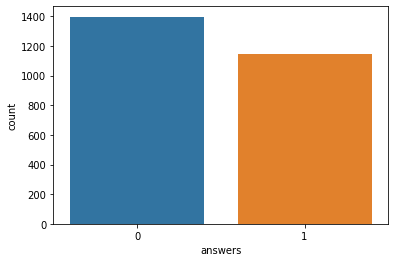

In [8]:
sns.countplot(all_data, x="answers")

In [9]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
    def forward(self, last_hidden_state, attention_masks):
        input_mask_expanded = attention_masks.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

class MultiSampleDropout(nn.Module):
    def __init__(self, max_dropout_rate, num_samples, classifier):
        super(MultiSampleDropout, self).__init__()
        self.dropout = nn.Dropout
        self.classifier = classifier
        self.max_dropout_rate = max_dropout_rate
        self.num_samples = num_samples
    def forward(self, out):
        return torch.mean(torch.stack([self.classifier(self.dropout(p=rate)(out)) for _, rate in enumerate(np.linspace(0, self.max_dropout_rate, self.num_samples))], dim=0), dim=0)
    

class NeuralCLF(nn.Module):
    def __init__(self, plm="monologg/kobigbird-bert-base", num_classes=2, max_dropout=0.2, num_dropout_samples=8):
        super(NeuralCLF, self).__init__()
        self.num_classes = num_classes 
        self.max_dropout = max_dropout
        self.num_dropout_samples = num_dropout_samples 
        self.config = AutoConfig.from_pretrained(plm)
        self.mean_pooler = MeanPooling()
        self.lm = AutoModel.from_pretrained(plm, config=self.config) 
        self.fc = nn.Linear(self.config.hidden_size, self.num_classes) 
        self.multi_dropout = MultiSampleDropout(self.max_dropout, self.num_dropout_samples, self.fc)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, input_ids, attn_masks):
        x = self.lm(input_ids, attn_masks)[0] 
        x = self.mean_pooler(x, attn_masks) 
        x = self.multi_dropout(x)  
        return x 

In [10]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten() 
    labels_flat = labels.flatten() 
    return np.sum(pred_flat == labels_flat) / len(labels_flat) 

In [11]:
queries = all_data["queries"].values 
passages = all_data["passages"].values
labels = all_data["answers"].values 

tokenizer = AutoTokenizer.from_pretrained("monologg/kobigbird-bert-base") 

input_ids, attn_masks = [], [] 
for i in tqdm(range(len(queries)), position=0, leave=True): 
    encoded_inputs = tokenizer(str(queries[i]), str(passages[i]), max_length=512, truncation=True, padding="max_length")
    input_ids.append(encoded_inputs["input_ids"]) 
    attn_masks.append(encoded_inputs["attention_mask"])  
    
input_ids = torch.tensor(input_ids, dtype=int) 
attn_masks = torch.tensor(attn_masks, dtype=int) 
labels = torch.tensor(labels, dtype=int) 

input_ids.shape, attn_masks.shape, labels.shape

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--monologg--kobigbird-bert-base/snapshots/ceacda477e20abef2c929adfa4a07c6f811323be/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--monologg--kobigbird-bert-base/snapshots/ceacda477e20abef2c929adfa4a07c6f811323be/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--monologg--kobigbird-bert-base/snapshots/ceacda477e20abef2c929adfa4a07c6f811323be/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--monologg--kobigbird-bert-base/snapshots/ceacda477e20abef2c929adfa4a07c6f811323be/tokenizer_config.json


  0%|          | 0/2545 [00:00<?, ?it/s]

(torch.Size([2545, 512]), torch.Size([2545, 512]), torch.Size([2545]))

In [12]:
train_size = int(input_ids.shape[0] * 0.8)
val_size = int(input_ids.shape[0] * 0.1) 

train_input_ids = input_ids[:train_size] 
train_attn_masks = attn_masks[:train_size] 
train_labels = labels[:train_size] 

val_input_ids = input_ids[train_size:train_size+val_size] 
val_attn_masks = attn_masks[train_size:train_size+val_size] 
val_labels = labels[train_size:train_size+val_size] 

test_input_ids = input_ids[train_size+val_size:] 
test_attn_masks = attn_masks[train_size+val_size:] 
test_labels = labels[train_size+val_size:] 

train_input_ids.shape, val_input_ids.shape, test_input_ids.shape

(torch.Size([2036, 512]), torch.Size([254, 512]), torch.Size([255, 512]))

In [13]:
batch_size = 32 

train_data = TensorDataset(train_input_ids, train_attn_masks, train_labels)
train_sampler = RandomSampler(train_data) 
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)  

val_data = TensorDataset(val_input_ids, val_attn_masks, val_labels) 
val_sampler = SequentialSampler(val_data) 
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)  

test_data = TensorDataset(test_input_ids, test_attn_masks, test_labels) 
test_sampler = SequentialSampler(test_data) 
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size) 

In [14]:
device = torch.device("cuda") 
best_val_loss = 999999999999
model = NeuralCLF() 
model.to(device) 
loss_func = nn.CrossEntropyLoss() 
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 10 
total_steps = len(train_dataloader) * epochs 
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.05*total_steps), num_training_steps=total_steps) 
model.zero_grad() 
for epoch_i in tqdm(range(0, epochs), desc="Epochs", position=0, leave=True, total=epochs):
    train_loss, train_accuracy = 0, 0 
    model.train() 
    with tqdm(train_dataloader, unit="batch") as tepoch: 
        for step, batch in enumerate(tepoch): 
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_attn_masks, b_labels = batch 
            outputs = model(b_input_ids, b_attn_masks) 
            loss = loss_func(outputs, b_labels) 
            train_loss += loss.item() 
            train_accuracy += flat_accuracy(outputs.detach().cpu().numpy(), b_labels.detach().cpu().numpy())            
            loss.backward() 
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
            optimizer.step() 
            scheduler.step() 
            model.zero_grad() 
            tepoch.set_postfix(loss=train_loss / (step+1), accuracy=train_accuracy/(step+1))
            time.sleep(0.1) 
    avg_train_loss = train_loss / len(train_dataloader) 
    avg_train_accuracy = train_accuracy / len(train_dataloader) 
    
    val_loss, val_accuracy = 0, 0 
    model.eval() 
    for step, batch in tqdm(enumerate(val_dataloader), position=0, leave=True, total=len(val_dataloader)): 
        batch = tuple(t.to(device) for t in batch) 
        b_input_ids, b_attn_masks, b_labels = batch 
        with torch.no_grad(): 
            outputs = model(b_input_ids, b_attn_masks) 
            loss = loss_func(outputs, b_labels) 
            val_loss += loss.item() 
            val_accuracy += flat_accuracy(outputs.detach().cpu().numpy(), b_labels.detach().cpu().numpy()) 
    avg_val_loss = val_loss / len(val_dataloader) 
    avg_val_accuracy = val_accuracy / len(val_dataloader)  
    
    print(f"avg train loss:{avg_train_loss} | avg train accuracy:{avg_train_accuracy} | avg val loss:{avg_val_loss} | avg val accuracy:{avg_val_accuracy}")
    
    if avg_val_loss < best_val_loss:
        print("saving current best checkpoint!") 
        best_val_loss = avg_val_loss 
        torch.save(model.state_dict(), "law_large_clf_bigbird.pt")
    
print(f"best val loss:{best_val_loss}")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--monologg--kobigbird-bert-base/snapshots/ceacda477e20abef2c929adfa4a07c6f811323be/config.json
Model config BigBirdConfig {
  "_name_or_path": "monologg/kobigbird-bert-base",
  "architectures": [
    "BigBirdForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "attention_type": "block_sparse",
  "block_size": 64,
  "bos_token_id": 5,
  "classifier_dropout": null,
  "eos_token_id": 6,
  "gradient_checkpointing": false,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 4096,
  "model_type": "big_bird",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_random_blocks": 3,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "rescale_embeddings": false,
  "sep_token_id": 3,
  "tokenizer_class": "BertTokenizer",
  "torch_dtype": "floa

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?batch/s]

Attention type 'block_sparse' is not possible if sequence_length: 512 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


  0%|          | 0/8 [00:00<?, ?it/s]

avg train loss:0.6424220115877688 | avg train accuracy:0.59736328125 | avg val loss:0.4839288331568241 | avg val accuracy:0.7684895833333334
saving current best checkpoint!


  0%|          | 0/64 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?it/s]

avg train loss:0.3909391809720546 | avg train accuracy:0.8353515625 | avg val loss:0.47721901535987854 | avg val accuracy:0.77265625
saving current best checkpoint!


  0%|          | 0/64 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?it/s]

avg train loss:0.2516128330025822 | avg train accuracy:0.9044921875 | avg val loss:0.3940008254721761 | avg val accuracy:0.8158854166666667
saving current best checkpoint!


  0%|          | 0/64 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?it/s]

avg train loss:0.19254817548790015 | avg train accuracy:0.92744140625 | avg val loss:0.4393469216302037 | avg val accuracy:0.84375


  0%|          | 0/64 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?it/s]

avg train loss:0.12942973086319398 | avg train accuracy:0.95703125 | avg val loss:0.7176562920212746 | avg val accuracy:0.8239583333333333


  0%|          | 0/64 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?it/s]

avg train loss:0.09442643234797288 | avg train accuracy:0.96875 | avg val loss:0.7320863232016563 | avg val accuracy:0.8239583333333333


  0%|          | 0/64 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?it/s]

avg train loss:0.0684601642024063 | avg train accuracy:0.97578125 | avg val loss:0.7957864124327898 | avg val accuracy:0.8200520833333333


  0%|          | 0/64 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?it/s]

avg train loss:0.05127768247621134 | avg train accuracy:0.98486328125 | avg val loss:0.8872785810381174 | avg val accuracy:0.8200520833333333


  0%|          | 0/64 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?it/s]

avg train loss:0.04073867454644642 | avg train accuracy:0.98974609375 | avg val loss:0.9129131510853767 | avg val accuracy:0.8239583333333333


  0%|          | 0/64 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?it/s]

avg train loss:0.04067189292618423 | avg train accuracy:0.9875 | avg val loss:0.9518848732113838 | avg val accuracy:0.8239583333333333
best val loss:0.3940008254721761


# Testing

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
checkpoint = torch.load("law_large_clf_bigbird.pt")
test_model = NeuralCLF()
test_model.load_state_dict(checkpoint) 
test_model.to(device)
test_model.eval() 
print() 

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--monologg--kobigbird-bert-base/snapshots/ceacda477e20abef2c929adfa4a07c6f811323be/config.json
Model config BigBirdConfig {
  "_name_or_path": "monologg/kobigbird-bert-base",
  "architectures": [
    "BigBirdForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "attention_type": "block_sparse",
  "block_size": 64,
  "bos_token_id": 5,
  "classifier_dropout": null,
  "eos_token_id": 6,
  "gradient_checkpointing": false,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 4096,
  "model_type": "big_bird",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_random_blocks": 3,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "rescale_embeddings": false,
  "sep_token_id": 3,
  "tokenizer_class": "BertTokenizer",
  "torch_dtype": "floa

In [23]:
test_predictions, ground_truths = [], []  

for step, batch in tqdm(enumerate(test_dataloader), position=0, leave=True, total=len(test_dataloader)): 
    batch = (t.to(device) for t in batch) 
    b_input_ids, b_attn_masks, b_labels = batch 
    with torch.no_grad(): 
        output = test_model(b_input_ids, b_attn_masks) 
        output_labels = torch.argmax(output, dim=1) 
        test_predictions.extend(output_labels.detach().cpu().numpy())
        ground_truths.extend(b_labels.detach().cpu().numpy())

  0%|          | 0/8 [00:00<?, ?it/s]

In [35]:
cnt = 0 
for i in range(len(test_predictions)): 
    if test_predictions[i] == ground_truths[i]: 
        cnt += 1 
        
accuracy = cnt / len(test_predictions) * 100 
f1 = f1_score(ground_truths, test_predictions, average="weighted")  

print(f"Accuracy:{accuracy}% | Weighted F1:{f1}") 

Accuracy:83.13725490196079% | Weighted F1:0.8322638890025339


In [53]:
import random 

accuracies = [] 
f1s = [] 

for iterations in tqdm(range(1000)): 
    cnt = 0 
    actions = [] 
    for i in range(len(ground_truths)): 
        action = random.randint(0,1)
        actions.append(action) 
    for i in range(len(ground_truths)):
        if actions[i] == ground_truths[i]: 
            cnt += 1 
    accuracy = cnt / len(ground_truths) 
    f1 = f1_score(ground_truths, actions, average="weighted") 
    accuracies.append(accuracy) 
    f1s.append(f1) 

  0%|          | 0/1000 [00:00<?, ?it/s]

In [54]:
np.mean(accuracies)*100, np.mean(f1s)

(49.924705882352946, 0.5014682437582313)

In [55]:
cnt = 0 
actions = [0 for _ in range(len(ground_truths))] 
for i in range(len(ground_truths)):
    if actions[i] == ground_truths[i]: 
        cnt += 1 
accuracy = cnt / len(ground_truths) 
f1 = f1_score(ground_truths, actions, average="weighted") 

accuracy*100, f1

(57.25490196078431, 0.4169184880934917)

In [56]:
cnt = 0 
actions = [1 for _ in range(len(ground_truths))] 
for i in range(len(ground_truths)):
    if actions[i] == ground_truths[i]: 
        cnt += 1 
accuracy = cnt / len(ground_truths) 
f1 = f1_score(ground_truths, actions, average="weighted") 

accuracy*100, f1

(42.745098039215684, 0.2560008618832148)